In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

from npiv import iv_simulator, custom_objectives, model_wrapper

In [2]:
# 0. random data.  price is endogenous, instrument is this 
n = 10000 # number of observations
d = 2 # dimensionality of the exogenous regressors in x
    
ivsim = iv_simulator.IVSimulator(num_exog_x_cols=d)
df = ivsim.generate_data(num_obs=n)
df['id'] = np.arange(n)

In [3]:
df.head()

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
0,-1.085631,0.997345,-2.911176,-0.062427,0.358411,0.075597,0.434008,-3.001299,0
1,0.282978,-1.506295,-3.156704,-0.865015,-0.484068,0.055417,-0.428650,0.365224,1
2,-0.578600,1.651437,-1.748911,0.758610,1.606738,-0.025814,1.580924,-1.169309,2
3,-2.426679,-0.428913,-3.764864,-2.019208,-1.710488,-0.012513,-1.723001,4.389678,3
4,1.265936,-0.866740,-4.289064,0.282274,0.547740,-0.091385,0.456354,-0.240278,4


In [4]:
print(ivsim.exog_x_cols, ivsim.endog_x_col, ivsim.instrument_col, ivsim.y_col)
display(ivsim.log_cost_coefs)
display(ivsim.log_sales_coefs)
display(df.describe())

['x_0', 'x_1'] log_price instrument log_sales


x_0    0.707107
x_1    0.707107
dtype: float64

x_0          0.707107
x_1          0.707107
log_price   -4.000000
dtype: float64

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.018369,0.001719,-3.998095,0.014204,0.424120,0.000942,0.425062,-1.263862,4999.50000
std,1.003899,0.996794,1.609220,1.013633,1.058928,0.057623,1.060207,3.620433,2886.89568
min,-3.801378,-3.685499,-6.798997,-3.492599,-3.127753,-0.099983,-3.132122,-17.948572,0.00000
25%,-0.666906,-0.686832,-5.394813,-0.676062,-0.306594,-0.048520,-0.304092,-3.116390,2499.75000
50%,0.014632,0.009468,-4.007687,0.001468,0.411439,0.001735,0.409161,-1.363713,4999.50000
75%,0.683905,0.681603,-2.616799,0.696894,1.137529,0.050727,1.136885,0.653906,7499.25000
max,3.676205,4.068097,-1.200855,3.628798,4.165641,0.099975,4.088933,14.160886,9999.00000


In [5]:
# 4. now compute some true quantiles
log_price_qtl_cols = []
interval = .1
qtls = np.arange(0,1,interval) + interval/2
print("computing these conditional quantiles of log price: {}".format(qtls))
for qtl in qtls:
    qcol = 'log_price_qtl_{:.3f}'.format(qtl)
    df[qcol] = ivsim.compute_log_price_quantile_given_cost_and_instrument(df['unobserved_log_cost'], df['instrument'], qtl)
    log_price_qtl_cols.append(qcol)
print("these are the relevant columns: {}".format(log_price_qtl_cols))

computing these conditional quantiles of log price: [ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95]
these are the relevant columns: ['log_price_qtl_0.050', 'log_price_qtl_0.150', 'log_price_qtl_0.250', 'log_price_qtl_0.350', 'log_price_qtl_0.450', 'log_price_qtl_0.550', 'log_price_qtl_0.650', 'log_price_qtl_0.750', 'log_price_qtl_0.850', 'log_price_qtl_0.950']


# predict qtl

In [6]:
df.head()

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id,log_price_qtl_0.050,log_price_qtl_0.150,log_price_qtl_0.250,log_price_qtl_0.350,log_price_qtl_0.450,log_price_qtl_0.550,log_price_qtl_0.650,log_price_qtl_0.750,log_price_qtl_0.850,log_price_qtl_0.950
0,-1.085631,0.997345,-2.911176,-0.062427,0.358411,0.075597,0.434008,-3.001299,0,0.179667,0.196835,0.217964,0.244612,0.279280,0.326262,0.393634,0.498678,0.686899,1.139181
1,0.282978,-1.506295,-3.156704,-0.865015,-0.484068,0.055417,-0.428650,0.365224,1,-0.643101,-0.625933,-0.604803,-0.578155,-0.543488,-0.496506,-0.429134,-0.324090,-0.135869,0.316413
2,-0.578600,1.651437,-1.748911,0.758610,1.606738,-0.025814,1.580924,-1.169309,2,0.899293,0.916461,0.937591,0.964239,0.998906,1.045888,1.113260,1.218304,1.406525,1.858807
3,-2.426679,-0.428913,-3.764864,-2.019208,-1.710488,-0.012513,-1.723001,4.389678,3,-1.865225,-1.848057,-1.826927,-1.800279,-1.765612,-1.718630,-1.651258,-1.546214,-1.357992,-0.905710
4,1.265936,-0.866740,-4.289064,0.282274,0.547740,-0.091385,0.456354,-0.240278,4,0.357385,0.374554,0.395683,0.422331,0.456998,0.503981,0.571353,0.676397,0.864618,1.316900


In [9]:
# divide into train/val/test
train_cutoff = int(n*.5)
val_cutoff = int(n*.7)
df_train = df.loc[df['id']<train_cutoff, :]
df_val = df.loc[(df['id']>=train_cutoff)&(df['id']<val_cutoff), :]
df_test = df.loc[df['id']>=val_cutoff, :].copy()
print(df_train.shape, df_val.shape, df_test.shape)

# construct lgb.datasets for prediction
x_cols = ivsim.exog_x_cols
y_col = ivsim.endog_x_col
print(x_cols, y_col)
dat_train = lgb.Dataset(df_train[x_cols], label=df_train[y_col])
dat_val = lgb.Dataset(df_val[x_cols], label=df_val[y_col])

(5000, 19) (2000, 19) (3000, 19)
['x_0', 'x_1'] log_price


In [153]:
def predict_eval_qtl(alpha_list):
    plot_df = df_test.sample(1000)
    num_alphas = len(alpha_list)
    fig, axes = plt.subplots(ncols=2, nrows=num_alphas, figsize=(6, 2*num_alphas))
    for (i, alpha) in enumerate(alpha_list):
        num_iters = 1000
        # print_every = max(num_iters//20, 10)
        print_every=0
        params = {
            'num_threads':4,
            'objective': 'quantile',
            'alpha': alpha, # which quantile to predict
            'metric': 'quantile',
            'num_leaves': 5,
            'learning_rate': 0.01,
            'feature_fraction': 0.5,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'max_delta_step':.1,
            'min_gain_to_split':10,
        }
        eval_results={}
        gbm = lgb.train(params, train_set=dat_train, valid_sets=[dat_train, dat_val], valid_names=['train', 'val'],
                        num_boost_round=num_iters, verbose_eval=print_every,
                        callbacks=[lgb.record_evaluation(eval_results)]
                        )
        # plot performance
        ax=axes[i][1]
        ax.grid()
        perfs = eval_results['val']['quantile']
        best_num_trees = np.argmin(perfs)
        ax.plot(eval_results['val']['quantile'])
        ax.axvline(best_num_trees, color='blue', linewidth=1)
        ax.set_title("val-set qtl loss, best iter = {}".format(best_num_trees, perfs[best_num_trees]))
        # predict on test set and compare
        true_qtl_col = 'log_price_qtl_{:.3f}'.format(alpha)
        tmp_plot_df = plot_df[[]].copy()
        tmp_plot_df['true quantile'] = plot_df[true_qtl_col]
        tmp_plot_df['predicted quantile'] = gbm.predict(plot_df[gbm.feature_name()], num_iteration=best_num_trees)
        tmp_plot_df.plot('true quantile', 'predicted quantile', kind='scatter', alpha=.3, s=2,
                        title = "{:.3f}-qtl of log_price".format(alpha),
                        grid=True, ax=axes[i][0]
                        )
        min_max_qtl = [tmp_plot_df['true quantile'].min(), tmp_plot_df['true quantile'].max()]
        axes[i][0].plot(min_max_qtl, min_max_qtl, color='red', linewidth=1)
    plt.tight_layout()
    #     return gbm


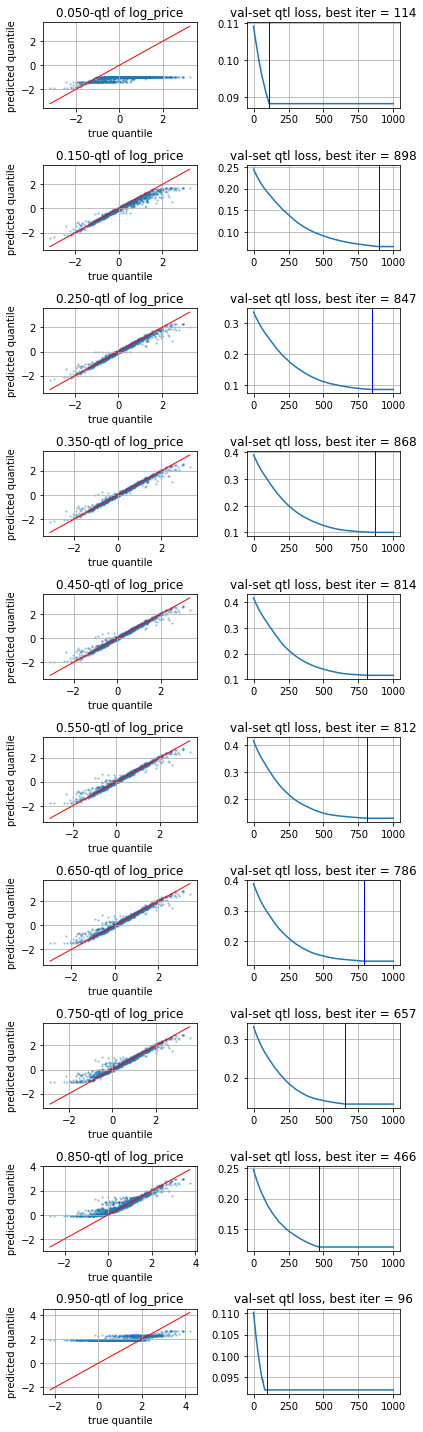

In [154]:
alpha_list = np.linspace(.05, .95, 10)
predict_eval_qtl(alpha_list)

In [ ]:
# extrema are bad.  whatever.